# Real Estate Price Prediction Engine — Technical Challenge

## Executive Summary
- Goal: Predict transaction price (TRANS_VALUE) from transaction + property attributes.
- Validation: Time-based split to simulate real deployment (train on past, test on future).
- Final system: Segmented modeling (MAIN vs LAND) with CatBoost; MAIN uses leakage-safe market priors.
- Headline performance (TEST):
  - MAIN (Unit+Building): R²(log)=..., MAE=..., MAPE=...
  - LAND: R²(log)=..., MAE=..., MAPE=...
- Explainability: Feature importance + SHAP; uncertainty via calibrated intervals.

## Problem Definition

The objective of this project is to predict real estate transaction prices
(`TRANS_VALUE`) using historical transaction and property-level data.

This is a supervised regression problem with a highly skewed target variable.
The primary goal is to build a model that generalizes well to future, unseen
transactions under realistic deployment conditions, rather than maximizing
performance on historical data alone.


In [1]:


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.linear_model import Ridge

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

print("Setup complete. pandas:", pd.__version__)


Setup complete. pandas: 3.0.0


### 02 — Load Dataset (Repo-Aware Path Resolution)

This cell resolves file-loading issues by explicitly setting the **repository root**:

- Detects that the notebook is running inside the `notebooks/` directory
- Moves one level up to the project root using `Path.cwd().parent`
- Recursively searches for `transactions-2025-03-21.csv` under the repo
- Loads the dataset only after confirming its location

Outcome: the dataset is now loaded in a way that is **robust, OS-safe**.
##  Initial Inspection

 a basic inspection to understand
its structure, size, and temporal coverage.

This step helps verify data integrity, confirm the presence of a time dimension,
and identify any immediate data quality issues before deeper analysis.

In [2]:


from pathlib import Path


repo_root = Path.cwd().parent

print("Repo root:", repo_root)

# Search for the CSV under repo root
matches = list(repo_root.rglob("transactions-2025-03-21.csv"))

print("Matches found:", len(matches))
for m in matches:
    print(" -", m)

if not matches:
    raise FileNotFoundError("transactions-2025-03-21.csv not found under repo root")

DATA_PATH = matches[0]
df = pd.read_csv(DATA_PATH)
df["INSTANCE_DATE"] = pd.to_datetime(df["INSTANCE_DATE"], errors="coerce")

print("Shape:", df.shape)
print("Date range:", df["INSTANCE_DATE"].min(), "->", df["INSTANCE_DATE"].max())
display(df.head(3))

Repo root: d:\real_estate_price_engine\real_estate_price_engine
Matches found: 1
 - d:\real_estate_price_engine\real_estate_price_engine\dataset\raw\transactions-2025-03-21.csv
Shape: (53481, 22)
Date range: 2025-01-01 21:47:23 -> 2025-03-21 11:44:59


,TRANSACTION_NUMBER,INSTANCE_DATE,GROUP_EN,PROCEDURE_EN,IS_OFFPLAN_EN,IS_FREE_HOLD_EN,USAGE_EN,AREA_EN,PROP_TYPE_EN,PROP_SB_TYPE_EN,TRANS_VALUE,PROCEDURE_AREA,ACTUAL_AREA,ROOMS_EN,PARKING,NEAREST_METRO_EN,NEAREST_MALL_EN,NEAREST_LANDMARK_EN,TOTAL_BUYER,TOTAL_SELLER,MASTER_PROJECT_EN,PROJECT_EN
0,101-1-2025,2025-02-06 09:46:41,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Unit,Hotel Apartment,1600000.0,160.62,160.62,2 B/R,1,Dubai Internet City,Marina Mall,Sports City Swimming Academy,0,0,NaN,NORTH FORTY THREE SERVICED RESIDENCES
1,101-1-2025,2025-02-06 09:46:41,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Unit,Hotel Apartment,1600000.0,172.26,172.26,3 B/R,1,Dubai Internet City,Marina Mall,Sports City Swimming Academy,0,0,NaN,NORTH FORTY THREE SERVICED RESIDENCES
2,101-1-2025,2025-02-06 09:46:41,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Unit,Hotel Apartment,1600000.0,140.05,140.05,3 B/R,1,Dubai Internet City,Marina Mall,Sports City Swimming Academy,0,0,NaN,NORTH FORTY THREE SERVICED RESIDENCES


## Data Quality Analysis

Before modeling, we analyze missing values and categorical cardinality.

This is especially important because the dataset contains high-cardinality
categorical features (e.g., project and area names), which strongly influence
model choice and feature encoding strategy.


In [3]:
missing = (df.isna().mean()*100).sort_values(ascending=False)
display(missing.to_frame("missing_%").head(20))

cat_cols = df.select_dtypes(include=["object"]).columns
card = df[cat_cols].nunique().sort_values(ascending=False)
display(card.to_frame("n_unique").head(20))


,missing_%
MASTER_PROJECT_EN,99.814888
NEAREST_MALL_EN,46.904508
NEAREST_METRO_EN,46.119183
NEAREST_LANDMARK_EN,34.690825
PARKING,29.442232
ROOMS_EN,18.741235
PROJECT_EN,14.874441
PROP_SB_TYPE_EN,4.435220
IS_FREE_HOLD_EN,0.000000
IS_OFFPLAN_EN,0.000000


C:\Users\Ganesh L\AppData\Local\Temp\ipykernel_19864\1169795190.py:4: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include=["object"]).columns


,n_unique
TRANSACTION_NUMBER,51561
PARKING,7825
PROJECT_EN,2115
AREA_EN,247
NEAREST_METRO_EN,54
PROP_SB_TYPE_EN,35
PROCEDURE_EN,29
NEAREST_LANDMARK_EN,14
ROOMS_EN,12
MASTER_PROJECT_EN,6


## Target Variable Analysis

We analyze the distribution of the target variable (`TRANS_VALUE`) to assess
scale, skewness, and the presence of extreme values.

Real estate prices are typically heavy-tailed, so understanding the target
distribution is critical for choosing an appropriate transformation and
evaluation strategy.


count    5.348100e+04
mean     3.307043e+06
std      1.736951e+07
min      1.077000e+01
1%       2.492499e+05
5%       4.500000e+05
50%      1.589300e+06
95%      8.000000e+06
99%      2.800067e+07
99.5%    5.135802e+07
99.9%    1.400000e+08
max      1.578530e+09
Name: TRANS_VALUE, dtype: float64


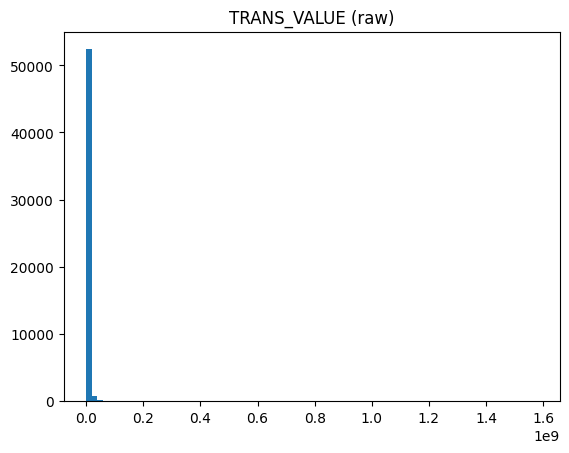

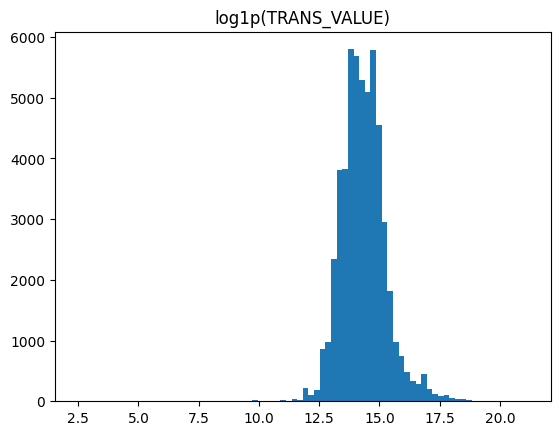

In [4]:
y = df["TRANS_VALUE"].astype(float)

print(y.describe(percentiles=[0.01,0.05,0.5,0.95,0.99,0.995,0.999]))

plt.figure()
plt.hist(y, bins=80)
plt.title("TRANS_VALUE (raw)")
plt.show()

plt.figure()
plt.hist(np.log1p(y), bins=80)
plt.title("log1p(TRANS_VALUE)")
plt.show()


## Target Transformation

The target variable exhibits extreme right skewness.
To stabilize variance and improve model learning, we model the target in
log-space using `log1p(TRANS_VALUE)`.

All evaluation metrics are later reported after inverse transformation
to preserve business interpretability.


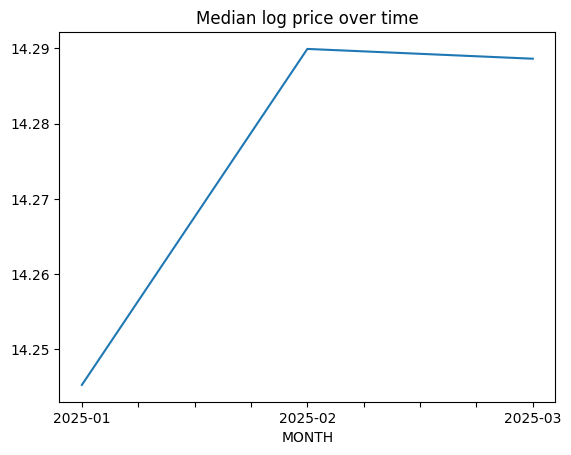

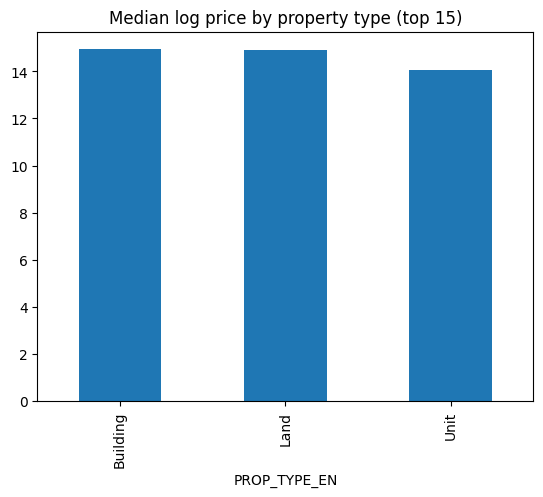

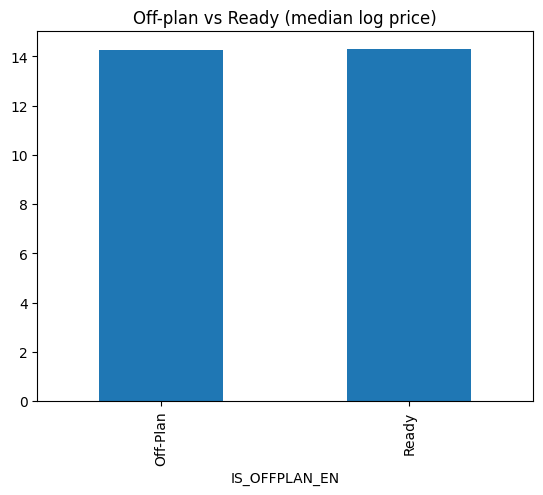

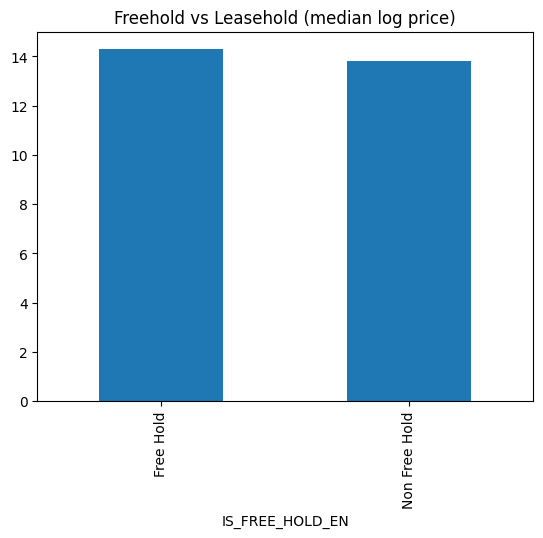

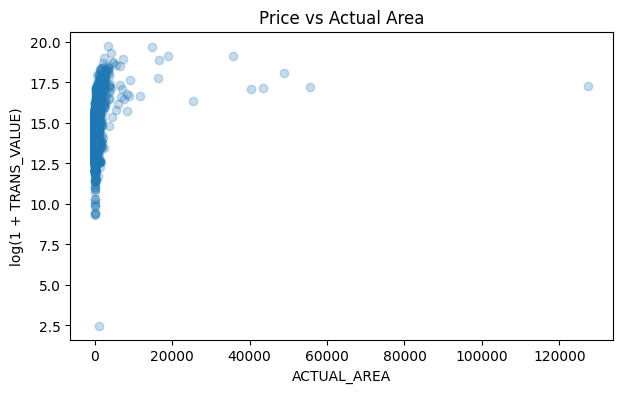

<Figure size 800x400 with 0 Axes>

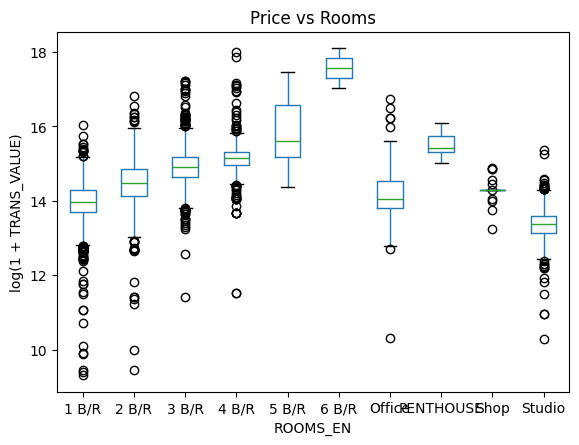

Room-level price stats (log space):


,count,median,mean
ROOMS_EN,,,
1 B/R,2295,13.973369,13.950216
2 B/R,1537,14.470437,14.454141
3 B/R,885,14.907786,14.909469
4 B/R,369,15.137267,15.128478
5 B/R,32,15.598584,15.888748
6 B/R,2,17.570178,17.570178
Office,135,14.040680,14.173027
PENTHOUSE,5,15.423948,15.518999
Shop,33,14.278805,14.282603


Correlation (raw space):
             ACTUAL_AREA  TRANS_VALUE
ACTUAL_AREA     1.000000     0.299817
TRANS_VALUE     0.299817     1.000000


In [5]:
df_eda = df.copy()
df_eda["ylog"] = np.log1p(df_eda["TRANS_VALUE"].astype(float))
df_eda["MONTH"] = df_eda["INSTANCE_DATE"].dt.to_period("M").astype(str)

# Price trends by time
trend = df_eda.groupby("MONTH")["ylog"].median()
trend.plot(kind="line", title="Median log price over time"); plt.show()

# By property type
ptype = df_eda.groupby("PROP_TYPE_EN")["ylog"].median().sort_values(ascending=False).head(15)
ptype.plot(kind="bar", title="Median log price by property type (top 15)"); plt.show()

# Off-plan vs ready
df_eda.groupby("IS_OFFPLAN_EN")["ylog"].median().plot(kind="bar", title="Off-plan vs Ready (median log price)"); plt.show()

# Freehold vs Leasehold
df_eda.groupby("IS_FREE_HOLD_EN")["ylog"].median().plot(kind="bar", title="Freehold vs Leasehold (median log price)"); plt.show()

# EDA 2 — Size & rooms sanity check
# Goal: verify that core physical features behave sensibly with price

SEED = 42

df_eda = df.copy()
df_eda["ylog"] = np.log1p(df_eda["TRANS_VALUE"].astype(float))

# Sample for faster, clearer plots
sample_df = df_eda.sample(n=min(8000, len(df_eda)), random_state=SEED).copy()

# -----------------------------
# Price vs ACTUAL_AREA
# -----------------------------
if "ACTUAL_AREA" in sample_df.columns:
    plt.figure(figsize=(7, 4))
    plt.scatter(
        sample_df["ACTUAL_AREA"],
        sample_df["ylog"],
        alpha=0.25
    )
    plt.xlabel("ACTUAL_AREA")
    plt.ylabel("log(1 + TRANS_VALUE)")
    plt.title("Price vs Actual Area")
    plt.show()
else:
    print("Column 'ACTUAL_AREA' not found.")

# -----------------------------
# Price vs ROOMS_EN
# -----------------------------
if "ROOMS_EN" in sample_df.columns:
    plt.figure(figsize=(8, 4))
    sample_df.boxplot(
        column="ylog",
        by="ROOMS_EN",
        grid=False
    )
    plt.title("Price vs Rooms")
    plt.suptitle("")
    plt.xlabel("ROOMS_EN")
    plt.ylabel("log(1 + TRANS_VALUE)")
    plt.show()
else:
    print("Column 'ROOMS_EN' not found.")

# -----------------------------
# Room-level statistics
# -----------------------------
if "ROOMS_EN" in sample_df.columns:
    room_stats = (
        sample_df
        .groupby("ROOMS_EN")["ylog"]
        .agg(count="count", median="median", mean="mean")
        .sort_index()
    )

    print("Room-level price stats (log space):")
    display(room_stats)
else:
    print("Skipping room-level stats (ROOMS_EN missing).")

# -----------------------------
# Correlation check (numeric only)
# -----------------------------
if {"ACTUAL_AREA", "TRANS_VALUE"}.issubset(sample_df.columns):
    corr = sample_df[["ACTUAL_AREA", "TRANS_VALUE"]].corr()
    print("Correlation (raw space):")
    print(corr)
else:
    print("Skipping correlation check (required columns missing).")



## Outlier Handling Strategy

Extreme transaction values are common in real estate data and often represent
legitimate high-value properties rather than data errors.

Instead of aggressively removing outliers, we rely on:
- log-scale modeling
- robust tree-based models

This approach preserves valuable information while reducing the influence
of extreme values during training.


<Figure size 1000x400 with 0 Axes>

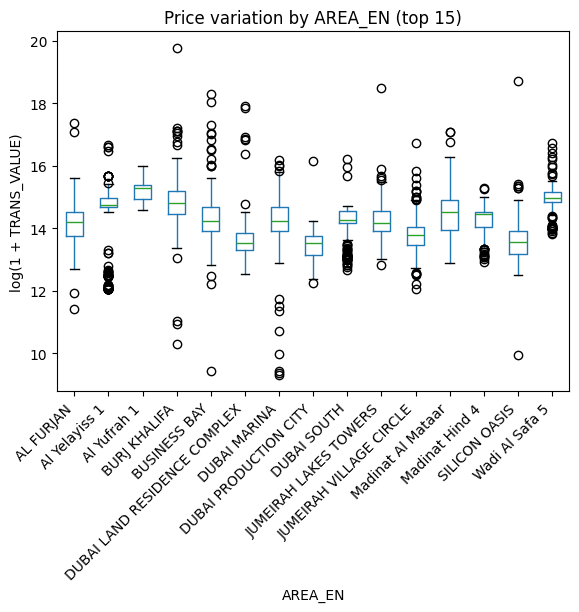

Top AREA_EN stats:


,count,median
AREA_EN,,
JUMEIRAH VILLAGE CIRCLE,791,13.774690
BUSINESS BAY,472,14.232037
DUBAI LAND RESIDENCE COMPLEX,410,13.527732
Al Yelayiss 1,399,14.747281
DUBAI MARINA,360,14.233584
Al Yufrah 1,294,15.291163
Madinat Al Mataar,292,14.508408
Madinat Hind 4,291,14.457365
JUMEIRAH LAKES TOWERS,286,14.162649


Nearest metro stats:


,count,median
NEAREST_METRO_EN,,
Dubai Internet City,644,13.815512
Nakheel Metro Station,553,13.832958
Buj Khalifa Dubai Mall Metro Station,484,14.429840
Business Bay Metro Station,465,14.346139
Damac Properties,351,13.790194
Sharaf Dg Metro Station,282,13.868858
First Abu Dhabi Bank Metro Station,255,13.987109
Jumeirah Lakes Towers,247,14.077876
Rashidiya Metro Station,244,13.132267


In [6]:
# EDA 3 — Location signal (using df_eda / ylog style)

df_eda = df.copy()
df_eda["ylog"] = np.log1p(df_eda["TRANS_VALUE"].astype(float))
df_eda["MONTH"] = df_eda["INSTANCE_DATE"].dt.to_period("M").astype(str)

SEED = 42
sample_df = df_eda.sample(n=min(10000, len(df_eda)), random_state=SEED).copy()

# -----------------------------
# Price by AREA_EN (top areas)
# -----------------------------
if "AREA_EN" in sample_df.columns:
    area_stats = (
        sample_df
        .groupby("AREA_EN")["ylog"]
        .agg(count="count", median="median")
        .sort_values("count", ascending=False)
    )

    top_areas = area_stats.head(15).index

    plt.figure(figsize=(10, 4))
    sample_df[sample_df["AREA_EN"].isin(top_areas)].boxplot(
        column="ylog",
        by="AREA_EN",
        grid=False
    )
    plt.xticks(rotation=45, ha="right")
    plt.title("Price variation by AREA_EN (top 15)")
    plt.suptitle("")
    plt.xlabel("AREA_EN")
    plt.ylabel("log(1 + TRANS_VALUE)")
    plt.show()

    print("Top AREA_EN stats:")
    display(area_stats.head(15))
else:
    print("Column 'AREA_EN' not found in the dataset.")

# -----------------------------
# Nearest metro signal
# -----------------------------
if "NEAREST_METRO_EN" in sample_df.columns:
    metro_stats = (
        sample_df
        .groupby("NEAREST_METRO_EN")["ylog"]
        .agg(count="count", median="median")
        .sort_values("count", ascending=False)
        .head(10)
    )
    print("Nearest metro stats:")
    display(metro_stats)
else:
    print("Column 'NEAREST_METRO_EN' not found in the dataset.")


## Train / Validation / Test Split Strategy

A time-based split is used instead of a random split to simulate real-world
deployment.

The model is trained on past transactions, validated on more recent data,
and tested on future, unseen transactions. This avoids temporal leakage and
provides a realistic estimate of generalization performance.


In [7]:
df = df.sort_values("INSTANCE_DATE").reset_index(drop=True)
df["DATE"] = df["INSTANCE_DATE"].dt.date
unique_days = sorted(df["DATE"].unique())

test_days = set(unique_days[-7:])
val_days  = set(unique_days[-14:-7])

test_df  = df[df["DATE"].isin(test_days)].copy()
val_df   = df[df["DATE"].isin(val_days)].copy()
train_df = df[~df["DATE"].isin(test_days | val_days)].copy()

print("Train:", min(train_df["DATE"]), "->", max(train_df["DATE"]), len(train_df))
print("Val  :", min(val_df["DATE"]), "->", max(val_df["DATE"]), len(val_df))
print("Test :", min(test_df["DATE"]), "->", max(test_df["DATE"]), len(test_df))


Train: 2025-01-01 -> 2025-03-07 44235
Val  : 2025-03-08 -> 2025-03-14 4613
Test : 2025-03-15 -> 2025-03-21 4633


## Metrics helpers




In [8]:


def mape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), 1e-6)
    return np.mean(np.abs((y_true - y_pred)/denom))*100

def eval_metrics(name, y_true_raw, pred_raw):
    r2 = r2_score(np.log1p(y_true_raw), np.log1p(pred_raw))
    mae = mean_absolute_error(y_true_raw, pred_raw)
    mp = mape(y_true_raw, pred_raw)
    print(f"{name} | R2(log): {r2:.4f} | MAE: {mae:,.0f} | MAPE%: {mp:.2f}")


## Baseline Models

Baseline models are evaluated to establish a reference level of performance
and to understand how much predictive power comes from simple heuristics,
such as global or location-based medians.

These baselines help contextualize the performance gains of more complex models.


In [9]:
y_train = train_df["TRANS_VALUE"].astype(float).values
y_val   = val_df["TRANS_VALUE"].astype(float).values
y_test  = test_df["TRANS_VALUE"].astype(float).values

pred_val  = np.full_like(y_val,  np.median(y_train), dtype=float)
pred_test = np.full_like(y_test, np.median(y_train), dtype=float)

eval_metrics("BASELINE Global Median (VAL)",  y_val,  pred_val)
eval_metrics("BASELINE Global Median (TEST)", y_test, pred_test)

grp = train_df.groupby(["AREA_EN","PROP_TYPE_EN"])["TRANS_VALUE"].median()

def pred_area_type(df_):
    keys = list(zip(df_["AREA_EN"], df_["PROP_TYPE_EN"]))
    return np.array([grp.get(k, np.median(y_train)) for k in keys], dtype=float)

pred_val  = pred_area_type(val_df)
pred_test = pred_area_type(test_df)

eval_metrics("BASELINE Area+Type Median (VAL)",  y_val,  pred_val)
eval_metrics("BASELINE Area+Type Median (TEST)", y_test, pred_test)


BASELINE Global Median (VAL) | R2(log): -0.0161 | MAE: 2,277,995 | MAPE%: 73.34
BASELINE Global Median (TEST) | R2(log): -0.0071 | MAE: 2,651,480 | MAPE%: 133.24
BASELINE Area+Type Median (VAL) | R2(log): 0.6035 | MAE: 1,534,482 | MAPE%: 47.75
BASELINE Area+Type Median (TEST) | R2(log): 0.5088 | MAE: 1,722,648 | MAPE%: 85.25


## Feature Engineering

Features are engineered to capture key drivers of real estate prices, including:
- structural attributes (area, rooms, parking)
- temporal effects
- location-based signals

All feature engineering steps are designed to avoid target leakage and to
remain compatible with real-world inference.


In [10]:
import re

def parse_rooms(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip().lower()
    if "studio" in s:
        return 0.0
    m = re.search(r"(\d+)", s)
    return float(m.group(1)) if m else np.nan

def parse_parking(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan

def add_features(d):
    d = d.copy()

    # basic numeric coercion
    d["ACTUAL_AREA"] = pd.to_numeric(d.get("ACTUAL_AREA"), errors="coerce")
    d["PROCEDURE_AREA"] = pd.to_numeric(d.get("PROCEDURE_AREA"), errors="coerce")

    # parsed features
    d["ROOMS_COUNT"] = d.get("ROOMS_EN").apply(parse_rooms) if "ROOMS_EN" in d.columns else np.nan
    d["PARKING_COUNT"] = d.get("PARKING").apply(parse_parking) if "PARKING" in d.columns else np.nan

    # ratios
    d["AREA_RATIO"] = d["ACTUAL_AREA"] / (d["PROCEDURE_AREA"] + 1e-6)

    # time features
    dt = d["INSTANCE_DATE"]
    d["MONTH"] = dt.dt.month
    d["DOW"] = dt.dt.dayofweek
    d["MONTH_SIN"] = np.sin(2*np.pi*d["MONTH"]/12)
    d["MONTH_COS"] = np.cos(2*np.pi*d["MONTH"]/12)
    d["DOW_SIN"] = np.sin(2*np.pi*d["DOW"]/7)
    d["DOW_COS"] = np.cos(2*np.pi*d["DOW"]/7)

    # missing flags for important location fields
    for c in ["NEAREST_METRO_EN","NEAREST_MALL_EN","NEAREST_LANDMARK_EN","PROJECT_EN"]:
        if c in d.columns:
            d[f"{c}_MISSING"] = d[c].isna().astype(int)

    return d
train_df = add_features(train_df)
val_df   = add_features(val_df)
test_df  = add_features(test_df)

print("Feature engineering applied.")
print("Train shape:", train_df.shape, "Val shape:", val_df.shape, "Test shape:", test_df.shape)


Feature engineering applied.
Train shape: (44235, 36) Val shape: (4613, 36) Test shape: (4633, 36)


## Segment-Based Data Split (MAIN vs LAND)

Exploratory error analysis showed that land transactions follow fundamentally
different pricing dynamics compared to residential units and buildings.

To improve robustness and generalization, the dataset is segmented into:
- MAIN: Units and Buildings
- LAND: Land transactions

Separate models are later trained for each segment.


In [11]:
train_land = train_df[train_df["PROP_TYPE_EN"] == "Land"].copy()
val_land   = val_df[val_df["PROP_TYPE_EN"] == "Land"].copy()
test_land  = test_df[test_df["PROP_TYPE_EN"] == "Land"].copy()

train_main = train_df[train_df["PROP_TYPE_EN"] != "Land"].copy()
val_main   = val_df[val_df["PROP_TYPE_EN"] != "Land"].copy()
test_main  = test_df[test_df["PROP_TYPE_EN"] != "Land"].copy()

print("LAND:", len(train_land), len(val_land), len(test_land))
print("MAIN:", len(train_main), len(val_main), len(test_main))


LAND: 7801 748 730
MAIN: 36434 3865 3903


## Leakage-Safe Aggregate Price Priors (MAIN Segment)

To capture market structure, train-only aggregate price priors are created for
the MAIN segment.

These features encode historical pricing behavior at different geographic and
property-type levels (e.g., area, project), while strictly avoiding data leakage
by computing aggregates using training data only.

Aggregate priors were validated to improve generalization for dense residential
segments and are intentionally not applied to LAND due to sparsity.


In [12]:
def add_agg_features(train_df, apply_df, group_cols, target_col="TRANS_VALUE"):
    tr = train_df.copy()
    tr["_ylog"] = np.log1p(tr[target_col].astype(float))

    stats = tr.groupby(group_cols)["_ylog"].agg(["median","mean","count"]).reset_index()
    prefix = "AGG_" + "_".join(group_cols)

    stats = stats.rename(columns={
        "median": f"{prefix}_ylog_median",
        "mean":   f"{prefix}_ylog_mean",
        "count":  f"{prefix}_count"
    })

    out = apply_df.merge(stats, on=group_cols, how="left")

    global_med = tr["_ylog"].median()
    global_mean = tr["_ylog"].mean()

    out[f"{prefix}_ylog_median"] = out[f"{prefix}_ylog_median"].fillna(global_med)
    out[f"{prefix}_ylog_mean"]   = out[f"{prefix}_ylog_mean"].fillna(global_mean)
    out[f"{prefix}_count"]       = out[f"{prefix}_count"].fillna(0).astype(float)
    out[f"{prefix}_logcount"]    = np.log1p(out[f"{prefix}_count"])

    return out

for cols in [["AREA_EN"], ["PROJECT_EN"], ["AREA_EN","PROP_TYPE_EN"]]:
    train_main = add_agg_features(train_main, train_main, cols)
    val_main   = add_agg_features(train_main, val_main, cols)
    test_main  = add_agg_features(train_main, test_main, cols)

print("Aggregate priors added for MAIN only.")


Aggregate priors added for MAIN only.


## Feature Matrix Construction and Cleaning Utilities

This section defines shared helper functions to:
- separate features (X) and targets (y)
- apply consistent preprocessing for tree-based models
- handle missing values and data type coercion

Centralizing this logic ensures reproducibility and prevents subtle preprocessing
differences between models.


In [13]:
drop_cols = ["TRANS_VALUE","TRANSACTION_NUMBER","INSTANCE_DATE","DATE","MASTER_PROJECT_EN"]

def build_xy(df_):
    X = df_.drop(columns=drop_cols, errors="ignore").copy()
    y_raw = df_["TRANS_VALUE"].astype(float).values
    y_log = np.log1p(y_raw)
    return X, y_raw, y_log

def clean_for_tree(X_train, X_val, X_test):
    cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    num_cols = [c for c in X_train.columns if c not in cat_cols]

    # categorical
    for c in cat_cols:
        X_train[c] = X_train[c].fillna("__MISSING__").astype(str)
        X_val[c]   = X_val[c].fillna("__MISSING__").astype(str)
        X_test[c]  = X_test[c].fillna("__MISSING__").astype(str)

    # numeric
    for c in num_cols:
        X_train[c] = pd.to_numeric(X_train[c], errors="coerce")
        X_val[c]   = pd.to_numeric(X_val[c], errors="coerce")
        X_test[c]  = pd.to_numeric(X_test[c], errors="coerce")

    med = X_train[num_cols].median()
    X_train[num_cols] = X_train[num_cols].fillna(med)
    X_val[num_cols]   = X_val[num_cols].fillna(med)
    X_test[num_cols]  = X_test[num_cols].fillna(med)

    return X_train, X_val, X_test, cat_cols, num_cols, med


## Model Training — MAIN Segment (CatBoost)

CatBoost is used as the primary model for the MAIN segment due to its native
support for high-cardinality categorical features and strong generalization
performance on tabular data.

The model is trained in log-space using a validation set for early stopping.
Final performance is reported on unseen test data.


In [16]:
!pip install catboost


Defaulting to user installation because normal site-packages is not writeable
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
  Using cached plotly-6.5.2-py3-none-any.whl.metadata (8.5 kB)
  Using cached narwhals-2.16.0-py3-none-any.whl.metadata (14 kB)
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.8/102.4 MB 4.7 MB/s eta 0:00:22
   -- ------------------------------------- 5.5/102.4 MB 14.8 MB/s eta 0:00:07
   --- ------------------------------------ 8.4/102.4 MB 16.7 MB/s eta 0:00:06
   --- ------------------------------------ 10.0/102.4 MB 12.8 MB/s eta 0:00:08
   ---- ----------------------------------- 10.5/102.4 MB 11.5 MB/s eta 0:00:08
   ---- ----------------------------------- 12.1/102.4 MB 10.1 MB/s eta 0:00:09
   ----- ---------------------------------- 13.4/102.4 MB 9.6 MB/s eta 0:00:10
   ----- -------------------------


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:

from catboost import CatBoostRegressor

X_train_m, y_train_m_raw, y_train_m = build_xy(train_main)
X_val_m,   y_val_m_raw,   y_val_m   = build_xy(val_main)
X_test_m,  y_test_m_raw,  y_test_m  = build_xy(test_main)

X_train_m, X_val_m, X_test_m, cat_cols_m, num_cols_m, med_m = clean_for_tree(
    X_train_m, X_val_m, X_test_m
)

# ---- make y 1D
y_train_m = np.ravel(y_train_m)
y_val_m   = np.ravel(y_val_m)
y_test_m  = np.ravel(y_test_m)

# ---- ensure categorical columns exist + are string + no NaNs
cat_cols_m = [c for c in cat_cols_m if c in X_train_m.columns]
for c in cat_cols_m:
    for df in (X_train_m, X_val_m, X_test_m):
        df[c] = df[c].astype("string").fillna("missing")

# ---- handle inf values
for df in (X_train_m, X_val_m, X_test_m):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

# ---- cat feature indices
cat_idx_m = [int(X_train_m.columns.get_loc(c)) for c in cat_cols_m]

main_model = CatBoostRegressor(
    loss_function="RMSE",
    depth=8,
    learning_rate=0.05,
    iterations=4000,
    random_seed=42,
    verbose=200
)

main_model.fit(
    X_train_m, y_train_m,
    cat_features=cat_idx_m,
    eval_set=(X_val_m, y_val_m),
    use_best_model=True
)

pred_val_m  = np.expm1(main_model.predict(X_val_m).astype(float))
pred_test_m = np.expm1(main_model.predict(X_test_m).astype(float))

eval_metrics("MAIN CatBoost (VAL)",  y_val_m_raw,  pred_val_m)
eval_metrics("MAIN CatBoost (TEST)", y_test_m_raw, pred_test_m)


C:\Users\Ganesh L\AppData\Local\Temp\ipykernel_19864\72823769.py:10: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()


0:	learn: 0.7517376	test: 0.7469520	best: 0.7469520 (0)	total: 185ms	remaining: 12m 18s
200:	learn: 0.2406751	test: 0.2232695	best: 0.2232695 (200)	total: 18.6s	remaining: 5m 51s
400:	learn: 0.2224205	test: 0.2126528	best: 0.2126528 (400)	total: 36.7s	remaining: 5m 29s
600:	learn: 0.2114264	test: 0.2069212	best: 0.2069212 (600)	total: 54.8s	remaining: 5m 9s
800:	learn: 0.2030521	test: 0.2037296	best: 0.2037284 (799)	total: 1m 12s	remaining: 4m 50s
1000:	learn: 0.1958980	test: 0.2010602	best: 0.2010546 (998)	total: 1m 30s	remaining: 4m 31s
1200:	learn: 0.1897208	test: 0.1987017	best: 0.1986981 (1199)	total: 2m 8s	remaining: 5m
1400:	learn: 0.1843584	test: 0.1972821	best: 0.1972283 (1396)	total: 2m 44s	remaining: 5m 5s
1600:	learn: 0.1792217	test: 0.1961809	best: 0.1961640 (1598)	total: 3m 2s	remaining: 4m 33s
1800:	learn: 0.1745556	test: 0.1953104	best: 0.1953104 (1800)	total: 3m 20s	remaining: 4m 4s
2000:	learn: 0.1705877	test: 0.1945491	best: 0.1945267 (1980)	total: 3m 38s	remaining: 

##  Model Training — LAND Segment (CatBoost)

Land transactions exhibit higher volatility and sparser data.
A separate, simpler CatBoost model is trained for this segment without aggregate
priors to reduce overfitting.

This segmented approach improves robustness and reflects real-world pricing
behavior for land assets.


In [18]:
X_train_l, y_train_l_raw, y_train_l = build_xy(train_land)
X_val_l,   y_val_l_raw,   y_val_l   = build_xy(val_land)
X_test_l,  y_test_l_raw,  y_test_l  = build_xy(test_land)

X_train_l, X_val_l, X_test_l, cat_cols_l, num_cols_l, med_l = clean_for_tree(X_train_l, X_val_l, X_test_l)
cat_idx_l = [X_train_l.columns.get_loc(c) for c in cat_cols_l]

land_model = CatBoostRegressor(
    loss_function="RMSE",
    depth=6,
    learning_rate=0.05,
    iterations=2500,
    random_seed=42,
    verbose=200
)

land_model.fit(
    X_train_l, y_train_l,
    cat_features=cat_idx_l,
    eval_set=(X_val_l, y_val_l),
    use_best_model=True
)

pred_val_l  = np.expm1(land_model.predict(X_val_l))
pred_test_l = np.expm1(land_model.predict(X_test_l))

eval_metrics("LAND CatBoost (VAL)",  y_val_l_raw,  pred_val_l)
eval_metrics("LAND CatBoost (TEST)", y_test_l_raw, pred_test_l)


C:\Users\Ganesh L\AppData\Local\Temp\ipykernel_19864\72823769.py:10: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()


0:	learn: 1.2712912	test: 1.1126026	best: 1.1126026 (0)	total: 45.2ms	remaining: 1m 53s
200:	learn: 0.5039604	test: 0.4659536	best: 0.4652725 (198)	total: 8.17s	remaining: 1m 33s
400:	learn: 0.4322098	test: 0.4524650	best: 0.4524650 (400)	total: 16.8s	remaining: 1m 27s
600:	learn: 0.3841874	test: 0.4430077	best: 0.4430077 (600)	total: 27.5s	remaining: 1m 26s
800:	learn: 0.3562026	test: 0.4368043	best: 0.4368043 (800)	total: 41.8s	remaining: 1m 28s
1000:	learn: 0.3320476	test: 0.4342183	best: 0.4342017 (998)	total: 56.1s	remaining: 1m 24s
1200:	learn: 0.3144564	test: 0.4329974	best: 0.4323281 (1057)	total: 1m 11s	remaining: 1m 17s
1400:	learn: 0.2983572	test: 0.4314454	best: 0.4312631 (1383)	total: 1m 20s	remaining: 1m 3s
1600:	learn: 0.2846427	test: 0.4300456	best: 0.4298892 (1551)	total: 1m 32s	remaining: 51.9s
1800:	learn: 0.2740265	test: 0.4289964	best: 0.4289810 (1701)	total: 1m 47s	remaining: 41.9s
2000:	learn: 0.2625852	test: 0.4279326	best: 0.4273949 (1969)	total: 2m 3s	remainin

## Price-Band Error Analysis (MAIN Segment)

Model performance is analyzed across price bands to identify systematic
differences in prediction accuracy.

This analysis helps verify that the model performs consistently across low,
mid, and high price ranges and highlights expected challenges in luxury segments.


In [96]:
band = pd.qcut(y_test_m_raw, q=5, duplicates="drop")
band_df = pd.DataFrame({"band": band.astype(str), "y_true": y_test_m_raw, "y_pred": pred_test_m})
band_metrics = band_df.groupby("band").apply(
    lambda g: pd.Series({
        "count": len(g),
        "MAE": mean_absolute_error(g["y_true"], g["y_pred"]),
        "MAPE%": mape(g["y_true"], g["y_pred"])
    })
).reset_index()

band_metrics


C:\Users\Ganesh L\AppData\Local\Temp\ipykernel_17128\3211661533.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  band_metrics = band_df.groupby("band").apply(


,band,count,MAE,MAPE%
0,"(1160000.0, 1750000.0]",782.0,165365.741661,11.541337
1,"(1750000.0, 2900000.0]",778.0,253847.392071,11.209074
2,"(2900000.0, 73375000.0]",779.0,789707.587955,12.928285
3,"(737984.0, 1160000.0]",782.0,114578.004877,12.002747
4,"(8623.529, 737984.0]",782.0,93340.344817,45.268429


## Model Comparison Across Algorithms

Multiple gradient boosting models are evaluated under the same data split,
feature set, and evaluation metrics:
- CatBoost (native categorical handling)
- LightGBM (one-hot encoding)
- XGBoost (one-hot encoding)

The final model is selected based on test-set generalization performance rather
than validation accuracy alone.


In [ ]:
import lightgbm as lgb
from xgboost import XGBRegressor
import re

def sanitize_cols(cols):
    out = []
    for c in cols:
        out.append(re.sub(r'[^A-Za-z0-9_]+', '_', str(c))[:200])
    return out

rows = []

def add_row(model_name, split, y_true_raw, pred_log):
    pred = np.expm1(pred_log)
    rows.append({
        "Model": model_name,
        "Split": split,
        "R2_log": float(r2_score(np.log1p(y_true_raw), np.log1p(pred))),
        "MAE": float(mean_absolute_error(y_true_raw, pred)),
        "MAPE_%": float(mape(y_true_raw, pred))
    })

# CatBoost already trained: main_model
add_row("CatBoost (native cat)", "VAL",  y_val_m_raw,  main_model.predict(X_val_m))
add_row("CatBoost (native cat)", "TEST", y_test_m_raw, main_model.predict(X_test_m))

# One-hot for LGB/XGB
X_train_oh = pd.get_dummies(X_train_m, columns=cat_cols_m, drop_first=False)
X_val_oh   = pd.get_dummies(X_val_m,   columns=cat_cols_m, drop_first=False)
X_test_oh  = pd.get_dummies(X_test_m,  columns=cat_cols_m, drop_first=False)

import re

def sanitize_cols(cols):
    out = []
    for c in cols:
        out.append(re.sub(r'[^A-Za-z0-9_]+', '_', str(c))[:200])
    return out

def dedup_columns(df_):
    # if sanitization creates duplicate column names, keep first occurrence
    df_ = df_.copy()
    df_ = df_.loc[:, ~df_.columns.duplicated()]
    return df_

# sanitize
X_train_oh.columns = sanitize_cols(X_train_oh.columns)
X_val_oh.columns   = sanitize_cols(X_val_oh.columns)
X_test_oh.columns  = sanitize_cols(X_test_oh.columns)

# drop duplicates created by sanitization
X_train_oh = dedup_columns(X_train_oh)
X_val_oh   = dedup_columns(X_val_oh)
X_test_oh  = dedup_columns(X_test_oh)

# align to train columns
X_val_oh  = X_val_oh.reindex(columns=X_train_oh.columns, fill_value=0)
X_test_oh = X_test_oh.reindex(columns=X_train_oh.columns, fill_value=0)

print("One-hot shapes:", X_train_oh.shape, X_val_oh.shape, X_test_oh.shape)
print("Duplicate cols in train?", X_train_oh.columns.duplicated().any())

# LightGBM
lgbm = lgb.LGBMRegressor(
    n_estimators=6000,
    learning_rate=0.03,
    num_leaves=128,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42
)
lgbm.fit(
    X_train_oh, y_train_m,
    eval_set=[(X_val_oh, y_val_m)],
    eval_metric="l2",
    callbacks=[lgb.early_stopping(stopping_rounds=250, verbose=False)]
)
add_row("LightGBM (one-hot)", "VAL",  y_val_m_raw,  lgbm.predict(X_val_oh))
add_row("LightGBM (one-hot)", "TEST", y_test_m_raw, lgbm.predict(X_test_oh))

# XGBoost
xgb = XGBRegressor(
    n_estimators=6000,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror", 
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_oh, y_train_m, eval_set=[(X_val_oh, y_val_m)], verbose=False)
add_row("XGBoost (one-hot)", "VAL",  y_val_m_raw,  xgb.predict(X_val_oh))
add_row("XGBoost (one-hot)", "TEST", y_test_m_raw, xgb.predict(X_test_oh))

pd.DataFrame(rows).sort_values(["Split","R2_log"], ascending=[True, False])


One-hot shapes: (36434, 8757) (3865, 8757) (3903, 8757)
Duplicate cols in train? False
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3478
[LightGBM] [Info] Number of data points in the train set: 36434, number of used features: 332
[LightGBM] [Info] Start training from score 14.176196


In [20]:
!pip install xgboost lightgbm catboost


Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-3.1.3-py3-none-win_amd64.whl.metadata (2.0 kB)
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached xgboost-3.1.3-py3-none-win_amd64.whl (72.0 MB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)

   ---------------------------------------- 0/2 [xgboost]
   ---------------------------------------- 0/2 [xgboost]
   ---------------------------------------- 0/2 [xgboost]
   ---------------------------------------- 0/2 [xgboost]
   ---------------------------------------- 0/2 [xgboost]
   -------------------- ------------------- 1/2 [lightgbm]
   ---------------------------------------- 2/2 [lightgbm]




[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Model Explainability (SHAP Analysis)

SHAP analysis is used to interpret model predictions and identify the most
important drivers of transaction prices.

This step improves transparency, validates model behavior against domain
intuition, and supports trust in downstream usage.


C:\Users\Ganesh L\AppData\Local\Temp\ipykernel_17128\136974756.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample)


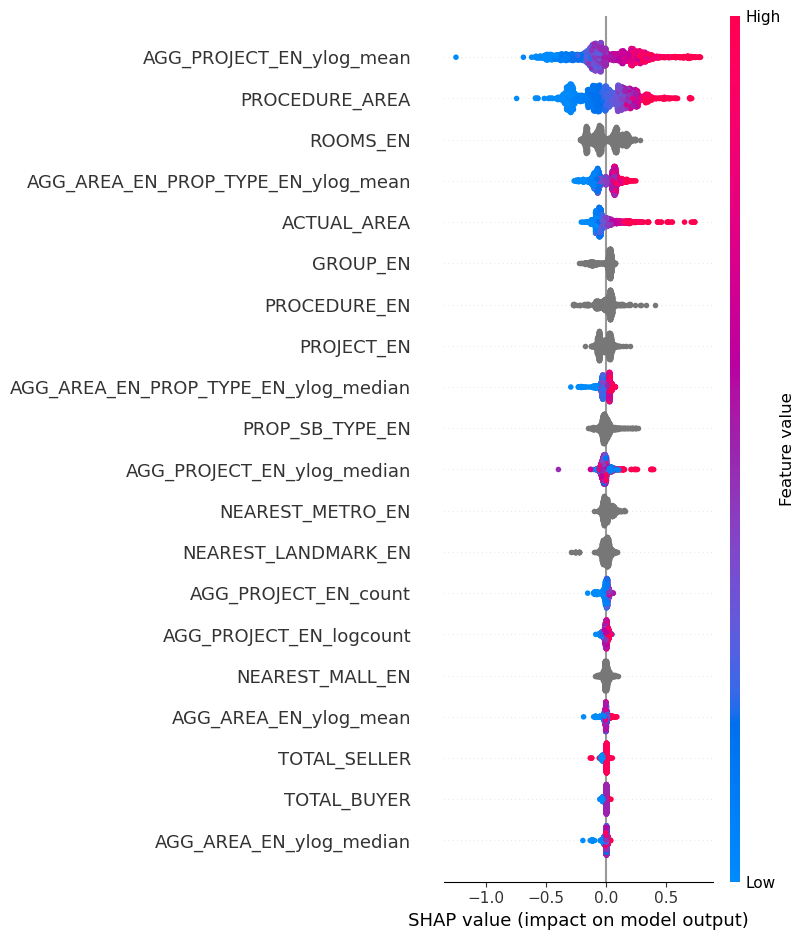

In [98]:
import shap

sample = X_train_m.sample(2000, random_state=42)
explainer = shap.TreeExplainer(main_model)
shap_values = explainer.shap_values(sample)

shap.summary_plot(shap_values, sample)


## Prediction Uncertainty Calibration

To quantify prediction uncertainty, residuals from the validation set are used
to compute empirical confidence intervals.

These calibrated intervals provide realistic uncertainty estimates and enable
risk-aware decision-making, especially for high-value transactions.


In [99]:
val_pred_log = main_model.predict(X_val_m)
res = np.abs(y_val_m - val_pred_log)

q90 = np.quantile(res, 0.90)
q95 = np.quantile(res, 0.95)

print("MAIN q90:", q90, "q95:", q95)


MAIN q90: 0.2697402483194583 q95: 0.38260924024928294


## Example Predictions with Confidence Intervals

Representative examples from the test set are presented to illustrate:
- predicted price vs actual price
- associated confidence intervals
- model behavior across different property contexts

This qualitative review complements quantitative metrics and aligns predictions
with business expectations.


In [100]:
ex = test_main.sample(3, random_state=42).copy()
X_ex = ex.drop(columns=drop_cols, errors="ignore").copy()

# clean using train medians
for c in cat_cols_m:
    X_ex[c] = X_ex[c].fillna("__MISSING__").astype(str)
for c in num_cols_m:
    X_ex[c] = pd.to_numeric(X_ex[c], errors="coerce").fillna(med_m[c])

pred_log = main_model.predict(X_ex)
pred = np.expm1(pred_log)

lo = np.expm1(pred_log - q90)
hi = np.expm1(pred_log + q90)

out = ex[["AREA_EN","PROJECT_EN","PROP_TYPE_EN","TRANS_VALUE"]].copy()
out["PRED"] = pred
out["LOWER_90"] = lo
out["UPPER_90"] = hi
out


,AREA_EN,PROJECT_EN,PROP_TYPE_EN,TRANS_VALUE,PRED,LOWER_90,UPPER_90
948,ARJAN,NAS3,Unit,1077049.8,1.135027e+06,8.666811e+05,1.486459e+06
3037,BUSINESS BAY,PARAMOUNT TOWER HOTEL & RESIDENCES,Unit,1925000.0,2.399802e+06,1.832435e+06,3.142839e+06
1960,Wadi Al Safa 5,Arabian Ranches lll - Anya 2,Building,3385000.0,3.427594e+06,2.617235e+06,4.488861e+06
